In this notebook we will demonstrate different text classification models trained using the IMDB reviews dataset. 

#### Extract zip file from web link (optional)

In [ ]:
link_to_zip_file='http://nlp.stanford.edu/data/glove.6B.zip' #862 mb (extract ? mb)
!wget -c 'http://nlp.stanford.edu/data/glove.6B.zip'

--2020-08-02 14:27:29--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-08-02 14:27:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-08-02 14:27:30--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
import zipfile
with zipfile.ZipFile('/content/glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall()

# Beginner

In [ ]:
#Make the necessary imports
import os
import sys
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from keras.models import Model, Sequential
from keras.initializers import Constant

Here we set all the paths of all the external datasets and models such as [glove](https://nlp.stanford.edu/projects/glove/) and [IMDB reviews dataset](http://ai.stanford.edu/~amaas/data/sentiment/).

#### Extract gz file from web link

In [ ]:
link_to_gz_file='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz' # 84 mb (extract to 240 mb)
!wget -c 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

--2020-08-02 14:35:31--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  19.3MB/s    in 8.9s    

2020-08-02 14:35:40 (9.00 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
import tarfile 
tar = tarfile.open("/content/aclImdb_v1.tar.gz") 
tar.extractall() 
for member in tar.getmembers(): 
  #print("Extracting %s" % member.name) 
  tar.extract(member) 

Preprocess

In [ ]:
#Declaring some of the constants we will use
BASE_DIR = '/content/' #change this to your local folder with these below datasets
#GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')#source: https://nlp.stanford.edu/projects/glove/
GLOVE_DIR=BASE_DIR
TRAIN_DATA_DIR = os.path.join(BASE_DIR, 'aclImdb/train') #source: http://ai.stanford.edu/~amaas/data/sentiment/
TEST_DATA_DIR = os.path.join(BASE_DIR, 'aclImdb/test') 

#Within these, I only have a pos/ and a neg/ folder containing text files 
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

#started off from: https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
#and from: https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py

In [ ]:
TRAIN_DATA_DIR

'/content/aclImdb/train'

In [ ]:
TEST_DATA_DIR
#/content/aclImdb/test

'/content/aclImdb/test'

In [ ]:
GLOVE_DIR

'/content/'

### Loading and Preprocessing
 

In [ ]:
os.listdir(TRAIN_DATA_DIR)

['unsup',
 'pos',
 'labeledBow.feat',
 'urls_unsup.txt',
 'unsupBow.feat',
 'neg',
 'urls_pos.txt',
 'urls_neg.txt']

In [ ]:
path='/content/sample_data'
os.path.isdir(path) 

True

In [ ]:
path='/content/aclImdb/train/pos'
os.path.isdir(path) 

True

In [ ]:
path='/content/aclImdb/train/urls_neg.txt'
os.path.isdir(path) 

False

In [ ]:
#Function to load the data from the dataset into the notebook. Will be called twice - for train and test.
def get_data(data_dir):
    texts = []  # list of text samples
    labels_index = {'pos':1, 'neg':0,'unsup':-1}  # dictionary mapping label name to numeric id
    # Add upsup: -1 to avoid error below
    labels = []  # list of label ids
    for name in sorted(os.listdir(data_dir)):
        path = os.path.join(data_dir, name)
        if path=='/content/aclImdb/train/unsup': continue
        print('path:',path)
        if os.path.isdir(path): #check xem path file co phai la folder hay khong
          label_id = labels_index[name] #folder name is also a label
          for fname in sorted(os.listdir(path)):
              fpath = os.path.join(path, fname)
              text = open(fpath).read()
              texts.append(text)
              labels.append(label_id)
    return texts, labels

train_texts, train_labels = get_data(TRAIN_DATA_DIR)
test_texts, test_labels = get_data(TEST_DATA_DIR)
labels_index = {'pos':1, 'neg':0} 

path: /content/aclImdb/train/labeledBow.feat
path: /content/aclImdb/train/neg
path: /content/aclImdb/train/pos
path: /content/aclImdb/train/unsupBow.feat
path: /content/aclImdb/train/urls_neg.txt
path: /content/aclImdb/train/urls_pos.txt
path: /content/aclImdb/train/urls_unsup.txt
path: /content/aclImdb/test/labeledBow.feat
path: /content/aclImdb/test/neg
path: /content/aclImdb/test/pos
path: /content/aclImdb/test/urls_neg.txt
path: /content/aclImdb/test/urls_pos.txt


In [ ]:
#Just to see how the data looks like. 
print(len(train_texts))
print(train_texts[0])
print(len(train_texts[0]))
print(train_labels[0])

print(len(test_texts))
print(test_texts[24999])
print(len(test_texts[0]))
print(test_labels[24999])

25000
Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.
655
0
25000
I've seen this story before but my kids haven't. Boy with troubled past joins military, faces his past, falls in love and becomes a man. The mentor this time is played perfectly by Kevin Costner; An ordinary man with common everyday problems who lives an extraordinary conviction, to save lives. After losing his team he takes

In [ ]:
pd.DataFrame(train_labels)[0].value_counts()

1    12500
0    12500
Name: 0, dtype: int64

In [ ]:
pd.DataFrame(test_labels)[0].value_counts()

1    12500
0    12500
Name: 0, dtype: int64

# 1. Tokenize the texts and convert them into word index vectors

In [ ]:
#Vectorize these text samples into a 2D integer tensor using Keras Tokenizer
#Tokenizer is fit on training data only, and that is used to tokenize both train and test data.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS) #20000
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts) #Converting text to a vector of word indexes
test_sequences = tokenizer.texts_to_sequences(test_texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
# max 20000 words keep in sequences, word index is just a show case, not use (> max words)


Found 88582 unique tokens.


In [ ]:
word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'he': 26,
 'be': 27,
 'one': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'who': 34,
 'so': 35,
 'from': 36,
 'like': 37,
 'her': 38,
 'or': 39,
 'just': 40,
 'about': 41,
 "it's": 42,
 'out': 43,
 'has': 44,
 'if': 45,
 'some': 46,
 'there': 47,
 'what': 48,
 'good': 49,
 'more': 50,
 'when': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'she': 56,
 'even': 57,
 'my': 58,
 'would': 59,
 'which': 60,
 'only': 61,
 'story': 62,
 'really': 63,
 'see': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'were': 68,
 'me': 69,
 'well': 70,
 'than': 71,
 'we': 72,
 'much': 73,
 'been': 74,
 'bad': 75,
 'get': 76,
 'will': 77,
 'do': 78,
 'also': 79,
 'into': 80,
 'people': 81,
 'other': 82,
 '

####EXPLAIN:

keras.Tokenizer:

- num_words: the maximum number of words to keep, based on word frequency. Only the most common num_words-1 words will be kept.
- filters: a string where each element is a character that will be filtered from the texts. The default is all punctuation, plus tabs and line breaks, minus the ' character.
- lower: boolean. Whether to convert the texts to lowercase.
- split: str. Separator for word splitting.
- char_level: if True, every character will be treated as a token.
- oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls

tokenizer.texts_to_sequences: give you a list of integer sequences encoding the words in your sentence, which is probably your use case:

In [ ]:
from keras.preprocessing.text import Tokenizer
# define 5 documents
docs = ['Well done!',
		'Good work',
		'Great effort',
    'Great job, man',
    'So good, keep working great',
		'nice work',
		'Excellent!']
# create the tokenizer
t = Tokenizer(num_words=5)
# fit the tokenizer on the documents
t.fit_on_texts(docs)
# summarize what was learned
print('word_counts\n',t.word_counts) #A dictionary of words and their counts.
print('document_count\n',t.document_count) # A dictionary of words and how many documents each appeared in.
print('word_index\n',t.word_index)# A dictionary of words and their uniquely assigned integers.
print('word_docs\n',t.word_docs)#An integer count of the total number of documents that were used to fit the Tokenizer.
# integer encode documents
encoded_docs = t.texts_to_matrix(docs, mode='count')
print('encoded_docs\n',encoded_docs)

word_counts
 OrderedDict([('well', 1), ('done', 1), ('good', 2), ('work', 2), ('great', 3), ('effort', 1), ('job', 1), ('man', 1), ('so', 1), ('keep', 1), ('working', 1), ('nice', 1), ('excellent', 1)])
document_count
 7
word_index
 {'great': 1, 'good': 2, 'work': 3, 'well': 4, 'done': 5, 'effort': 6, 'job': 7, 'man': 8, 'so': 9, 'keep': 10, 'working': 11, 'nice': 12, 'excellent': 13}
word_docs
 defaultdict(<class 'int'>, {'done': 1, 'well': 1, 'good': 2, 'work': 2, 'great': 3, 'effort': 1, 'job': 1, 'man': 1, 'so': 1, 'keep': 1, 'working': 1, 'nice': 1, 'excellent': 1})
encoded_docs
 [[0. 0. 0. 0. 1.]
 [0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0.]]


In [ ]:
text_sequences=t.texts_to_sequences(docs)
text_sequences

[[4], [2, 3], [1], [1], [2, 1], [3], []]

#### CONTINUE CHAPTER:

In [ ]:
print(len(train_texts))
print(len(train_texts[0]))
print(len(test_texts))
print(len(test_texts[0]))

25000
655
25000
900


In [ ]:
print(len(train_sequences)) # train_texts --> train_sequences
print(len(train_sequences[0]))
print(len(test_sequences))
print(len(test_sequences[0]))

25000
109
25000
164


In [ ]:
print(train_texts[0])
print(len(train_texts[0]))

Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.
655


In [ ]:
print(train_sequences[0]) # max 10000 words in sequences
print(len(train_sequences[0]))

[62, 4, 3, 129, 34, 44, 7576, 1414, 15, 3, 4252, 514, 43, 16, 3, 633, 133, 12, 6, 3, 1301, 459, 4, 1751, 209, 3, 10785, 7693, 308, 6, 676, 80, 32, 2137, 1110, 3008, 31, 1, 929, 4, 42, 5120, 469, 9, 2665, 1751, 1, 223, 55, 16, 54, 828, 1318, 847, 228, 9, 40, 96, 122, 1484, 57, 145, 36, 1, 996, 141, 27, 676, 122, 1, 13886, 411, 59, 94, 2278, 303, 772, 5, 3, 837, 11037, 20, 3, 1755, 646, 42, 125, 71, 22, 235, 101, 16, 46, 49, 624, 31, 702, 84, 702, 378, 3493, 12997, 2, 16816, 8422, 67, 27, 107, 3348]
109


# 2. Pad the text sequences so that all text vectors are of the same length.

#### Explain

In [ ]:
import tensorflow as tf
sequence = [[1], [10,8], [4, 9, 6]]
tf.keras.preprocessing.sequence.pad_sequences(sequence,maxlen=5)

array([[ 0,  0,  0,  0,  1],
       [ 0,  0,  0, 10,  8],
       [ 0,  0,  4,  9,  6]], dtype=int32)

In [ ]:
sequence = [train_sequences[0]]
print(sequence)
print(len(sequence[0]))

[[62, 4, 3, 129, 34, 44, 7576, 1414, 15, 3, 4252, 514, 43, 16, 3, 633, 133, 12, 6, 3, 1301, 459, 4, 1751, 209, 3, 10785, 7693, 308, 6, 676, 80, 32, 2137, 1110, 3008, 31, 1, 929, 4, 42, 5120, 469, 9, 2665, 1751, 1, 223, 55, 16, 54, 828, 1318, 847, 228, 9, 40, 96, 122, 1484, 57, 145, 36, 1, 996, 141, 27, 676, 122, 1, 13886, 411, 59, 94, 2278, 303, 772, 5, 3, 837, 11037, 20, 3, 1755, 646, 42, 125, 71, 22, 235, 101, 16, 46, 49, 624, 31, 702, 84, 702, 378, 3493, 12997, 2, 16816, 8422, 67, 27, 107, 3348]]
109


In [ ]:
a=tf.keras.preprocessing.sequence.pad_sequences(sequence,maxlen=200)
a

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,    62,     4,     3,   129,    34,    44,  7576,  1414,
           15,     3,  4252,   514,    43,    16,     3,   633,   133,
           12,     6,     3,  1301,   459,     4,  1751,   209,     3,
        10785,  7693,   308,     6,   676,    80,    32,  2137,  1110,
      

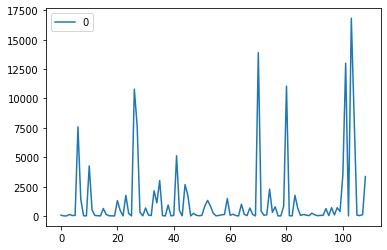

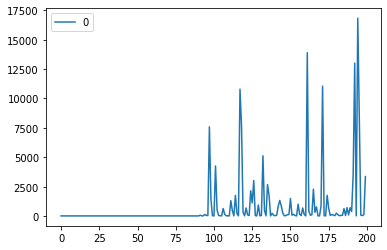

In [ ]:
pd.DataFrame(sequence[0]).plot()
pd.DataFrame(a[0]).plot()

#### Continue

In [ ]:
#Converting this to sequences to be fed into neural network. Max seq. len is 1000 as set earlier
#initial padding of 0s, until vector is of size MAX_SEQUENCE_LENGTH
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH) #1000
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH) #1000

In [ ]:
print(len(train_sequences)) # train_texts --> train_sequences
print(len(train_sequences[0]))
print(train_sequences[0])

25000
109
[62, 4, 3, 129, 34, 44, 7576, 1414, 15, 3, 4252, 514, 43, 16, 3, 633, 133, 12, 6, 3, 1301, 459, 4, 1751, 209, 3, 10785, 7693, 308, 6, 676, 80, 32, 2137, 1110, 3008, 31, 1, 929, 4, 42, 5120, 469, 9, 2665, 1751, 1, 223, 55, 16, 54, 828, 1318, 847, 228, 9, 40, 96, 122, 1484, 57, 145, 36, 1, 996, 141, 27, 676, 122, 1, 13886, 411, 59, 94, 2278, 303, 772, 5, 3, 837, 11037, 20, 3, 1755, 646, 42, 125, 71, 22, 235, 101, 16, 46, 49, 624, 31, 702, 84, 702, 378, 3493, 12997, 2, 16816, 8422, 67, 27, 107, 3348]


In [ ]:
print(trainvalid_data.shape)
trainvalid_data

(25000, 1000)


array([[   0,    0,    0, ...,   27,  107, 3348],
       [   0,    0,    0, ...,    1, 4517, 5457],
       [   0,    0,    0, ..., 1906,   15,  620],
       ...,
       [   0,    0,    0, ..., 1110,  205, 9755],
       [   0,    0,    0, ..., 3713,   14,   70],
       [   0,    0,    0, ...,   82,   93,   36]], dtype=int32)

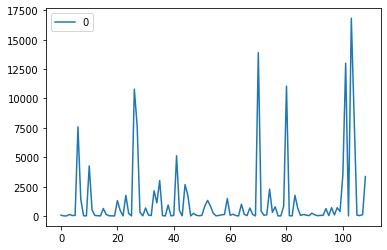

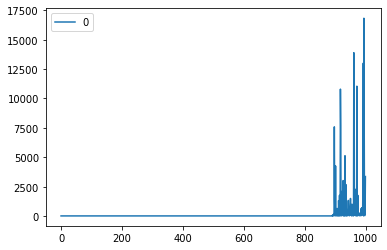

In [ ]:
pd.DataFrame(train_sequences[0]).plot()
# plot 109 tu, moi tu duoc the hien bang sequend index trong 20,000 tu
pd.DataFrame(trainvalid_data[0]).plot()
# plot 109 tu, moi tu duoc the hien bang sequend index trong 20,000 tu, tuy nhien
# tat ca duoc the hien trong padding 1000 (tu 900 --> 1000)

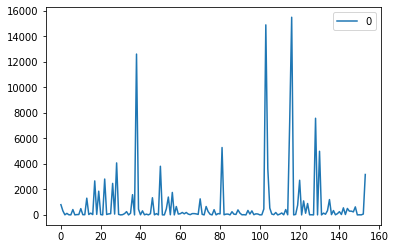

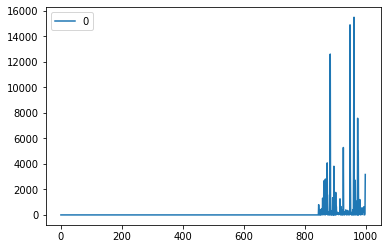

In [ ]:
num=3
pd.DataFrame(train_sequences[num]).plot()
pd.DataFrame(trainvalid_data[num]).plot()

In [ ]:
trainvalid_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))

In [ ]:
print(train_labels[:3])
print(trainvalid_labels.shape)
trainvalid_labels

[0, 0, 0]
(25000, 2)


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
print(VALIDATION_SPLIT)
print(trainvalid_data.shape[0])

0.2
25000


# Split the training data into a training set and a validation set

In [ ]:
indices = np.arange(trainvalid_data.shape[0])
np.random.shuffle(indices)
trainvalid_data = trainvalid_data[indices]
trainvalid_labels = trainvalid_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * trainvalid_data.shape[0])
x_train = trainvalid_data[:-num_validation_samples]
y_train = trainvalid_labels[:-num_validation_samples]
x_val = trainvalid_data[-num_validation_samples:]
y_val = trainvalid_labels[-num_validation_samples:]
#This is the data we will use for CNN and RNN training
print('Splitting the train data into train and valid is done')

Splitting the train data into train and valid is done


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)

(20000, 1000)
(20000, 2)
(5000, 1000)


In [ ]:
x_train

array([[    0,     0,     0, ...,   721,  3000,  1453],
       [    0,     0,     0, ...,     8,     1,   390],
       [    0,     0,     0, ...,     5,    58, 16590],
       ...,
       [    0,     0,     0, ...,   970,     2,   455],
       [    0,     0,     0, ...,     7,     7,   795],
       [    0,     0,     0, ...,   389,    15,    38]], dtype=int32)

#3. Map every word index to an embedding vector (for pre-train model| can skip if no need pre train)

We do that by multiplying
word index vectors with the embedding matrix. The embedding matrix can
either be populated using pre-trained embeddings or it can be trained for
embeddings on this corpus

Step 3: If we want to use pre-trained embeddings to convert the train and test data
into an embedding matrix like we did in the earlier examples with Word2vec and
fastText, we have to download them and use them to convert our data into the input
format for the neural networks. The following code snippet shows an example of
how to do this using GloVe embeddings, which were introduced in Chapter 3. GloVe
embeddings come with multiple dimensionalities, and we chose 100 as our
dimension here. The value of dimensionality is a hyperparameter, and we can
experiment with other dimensions as well:

#### Explain:

In [ ]:
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    i=0
    for line in f:
        values = line.split()
        print(values)
        word = values[0] # vocabulary name
        print(word)
        coefs = np.asarray(values[1:], dtype='float32') # embedding 100 dim
        print(coefs)
        print(len(coefs))
        embeddings_index[word] = coefs
        i+=1
        if i ==2 : break

['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538', '-0.30223

#### End explain

In [ ]:
print('Preparing embedding matrix.')

# first, build index mapping words in the embeddings set
# to their embedding vector
embeddings_index = {}
with open('/content/drive/My Drive/Data/NLP/glove.6B.100d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0] # vocabulary name
        coefs = np.asarray(values[1:], dtype='float32') # embedding 100 dim
        embeddings_index[word] = coefs

print('Found %s word vectors in Glove embeddings.' % len(embeddings_index))
print(embeddings_index["google"])

Preparing embedding matrix.
Found 400000 word vectors in Glove embeddings.
[ 0.22575  -0.56253  -0.05156  -0.079389  1.1876   -0.48397  -0.23342
 -0.85278   0.97495  -0.33344   0.71692   0.12644   0.31962  -1.4136
 -0.57903  -0.037286 -0.0164    0.45155  -0.29005   0.52599  -0.22534
 -0.29556  -0.032407  1.5608   -0.013499 -0.064558  0.26625   0.78595
 -0.71693  -0.93025   0.80461   1.6035   -0.30602  -0.34764   0.93872
  0.38137  -0.26743  -0.56519   0.58899  -0.14554  -0.34324   0.21291
 -0.39887   0.090042 -0.8495    0.38803  -0.5045   -0.22488   1.0644
 -0.2624    1.0334    0.06348  -0.39989   0.24236  -0.65636  -1.8107
 -0.061801  0.13795   1.1658   -0.30046  -0.50143   0.16509   0.039835
  0.62541   0.56935   0.64125   0.21308   0.30276   0.39673   0.38973
  0.28183   0.79481  -0.11962  -0.49598  -0.53195  -0.14897   0.51254
 -0.39208  -0.58535  -0.078509  0.81721  -0.73497  -0.68131   0.099243
 -0.87608   0.029632  0.33402  -0.14305   0.16964  -0.035178  0.39777
  0.71769   0.25

In [ ]:
# dang su dung embedding 100d cua glove, co the su dung thu vien 200 or 300d tuy luc
print(len(embeddings_index["google"]))
print(len(embeddings_index["apple"]))

100
100


In [ ]:
print(MAX_NUM_WORDS)
print(EMBEDDING_DIM)

20000
100


In [ ]:
# prepare embedding matrix - rows are the words from word_index, columns are the embeddings of that word from glove.
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
print(num_words)
print(embedding_matrix.shape)

20001
(20001, 100)


embeddings_index : chua toan bo embeddings words tu glove

In [ ]:
print(len(word_index)) # max 20000 tu hay gap nhat thoi, index nay khong xai het
print(len(embeddings_index))

88582
400000


word_index.items() :

dict_items([('the', 1), ('and', 2), ('a', 3), ('of', 4), ('to', 5), ('is', 6), ('br', 7), ('in', 8), ('it', 9), ('i', 10), ('this', 11), ('that', 12),

In [ ]:
for word, i in word_index.items():
    if i > MAX_NUM_WORDS: # chi thuc hien get embedding word < max_num_words(20000)
        continue
    embedding_vector = embeddings_index.get(word) #lay 100d embedding cho tung tu
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
print(embedding_matrix.shape)
embedding_matrix[1]

(20001, 100)


array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

Step 4: Now, we’re ready to train DL models for text classification! DL architectures
consist of an input layer, an output layer, and several hidden layers in between the
two. Depending on the architecture, different hidden layers are used. The input layer
for textual input is typically an embedding layer. The output layer, especially in the
context of text classification, is a softmax layer with categorical output. If we want
to train the input layer instead of using pre-trained embeddings, the easiest way is to
call the Embedding layer class in Keras, specifying the input and output
dimensions. However, since we want to use pre-trained embeddings, we should create a custom embedding layer that uses the embedding matrix we just built. The
following code snippet shows how to do that:

In [ ]:
# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(input_dim=num_words,#20001
                            output_dim=EMBEDDING_DIM, #100
                            embeddings_initializer=Constant(embedding_matrix), #(20001, 100)
                            input_length=MAX_SEQUENCE_LENGTH, #1000
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing of embedding matrix is done


tf.keras.layers.Embedding(

    input_dim: integer. Size of the vocabulary, i.e. maximum integer index + 1.
    output_dim:  Integer. Dimension of the dense embedding.
    embeddings_initializer="uniform": Initializer for the embeddings matrix
    embeddings_regularizer=None:Regularizer function applied to the embeddings matrix 
    activity_regularizer=None:
    embeddings_constraint=None:
    mask_zero=False:
    input_length=None:Length of input sequences, when it is constant. This argument is required if you are 
    going to connectFlatten then Dense layers upstream (without it, the shape of the dense outputs cannot be computed).
    **kwargs
)

This will serve as the input layer for any neural network we want to use (CNN or
LSTM). Now that we know how to pre-process the input and define an input layer,
let’s move on to specifying the rest of the neural network architecture using CNNs
and LSTMs.

# Build model

### 1D CNN Model with pre-trained embedding

Let’s now look at how to define, train, and evaluate a CNN model for text
classification. CNNs typically consist of a series of convolution and pooling layers
as the hidden layers. In the context of text classification, CNNs can be thought of as
learning the most useful bag-of-words/n-grams features instead of taking the entire
collection of words/n-grams as features, as we did earlier in this chapter. Since our
dataset has only two classes—positive and negative—the output layer has two
outputs, with the softmax activation function. We’ll define a CNN with three
convolution-pooling layers using the Sequential model class in Keras, which
allows us to specify DL models as a sequential stack of layers—one after another.
Once the layers and their activation functions are specified, the next task is to define
other important parameters, such as the optimizer, loss function, and the evaluation
metric to tune the hyperparameters of the model. Once all this is done, the next step
is to train and evaluate the model. The following code snippet shows one way of
specifying a CNN architecture for this task using the Python library Keras and prints
the results with the IMDB dataset for this model:

In [ ]:
# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(input_dim=num_words,#20001
                            output_dim=EMBEDDING_DIM, #100
                            embeddings_initializer=Constant(embedding_matrix), #(20001, 100)
                            input_length=MAX_SEQUENCE_LENGTH, #1000
                            trainable=False)
print("Preparing of embedding matrix is done")

Preparing of embedding matrix is done


In [ ]:
print('Define a 1D CNN model.')

cnnmodel = Sequential()
cnnmodel.add(embedding_layer)
cnnmodel.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(len(labels_index), activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
cnnmodel.summary()

Define a 1D CNN model.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1000, 100)         2000100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
global_max_pooling1d_1 (Glob (N

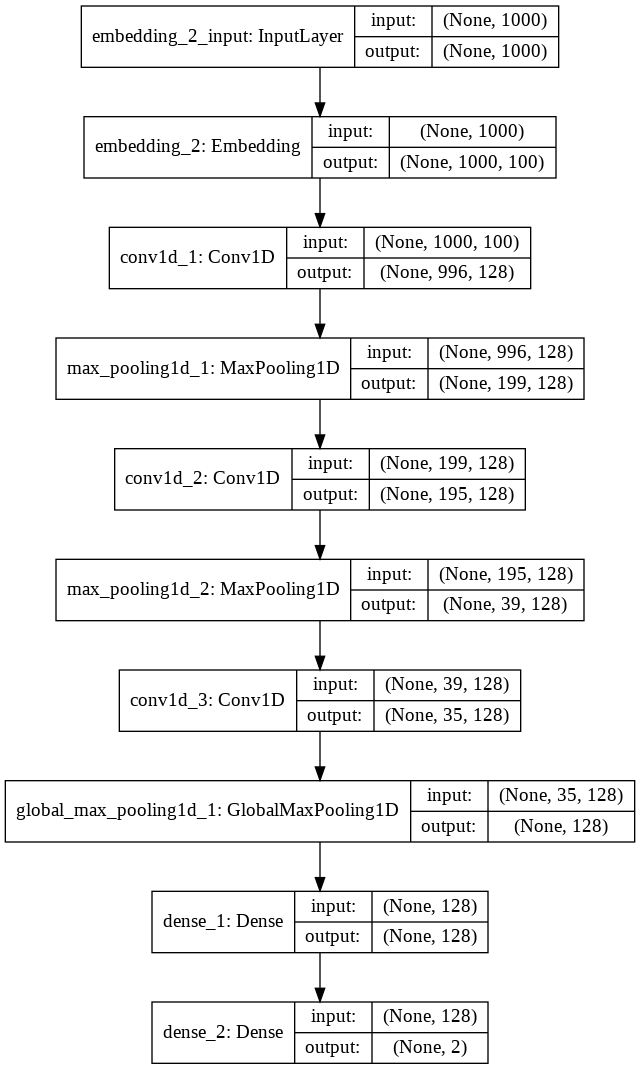

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(cnnmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Train the model. Tune to validation set. 
cnnmodel.fit(x_train, y_train,
          batch_size=128,
          epochs=1, validation_data=(x_val, y_val))
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

Train on 20000 samples, validate on 5000 samples
Epoch 1/1
25000/25000 [==============================] - 86s 3ms/step
Test accuracy with CNN: 0.7266799807548523


### 1D CNN model with training your own embedding

In [64]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000 
EMBEDDING_DIM = 100 
VALIDATION_SPLIT = 0.2

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, None, 128)         2560000   
_________________________________________________________________
conv1d_42 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, None, 128)         0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, None, 128)         82048     
________

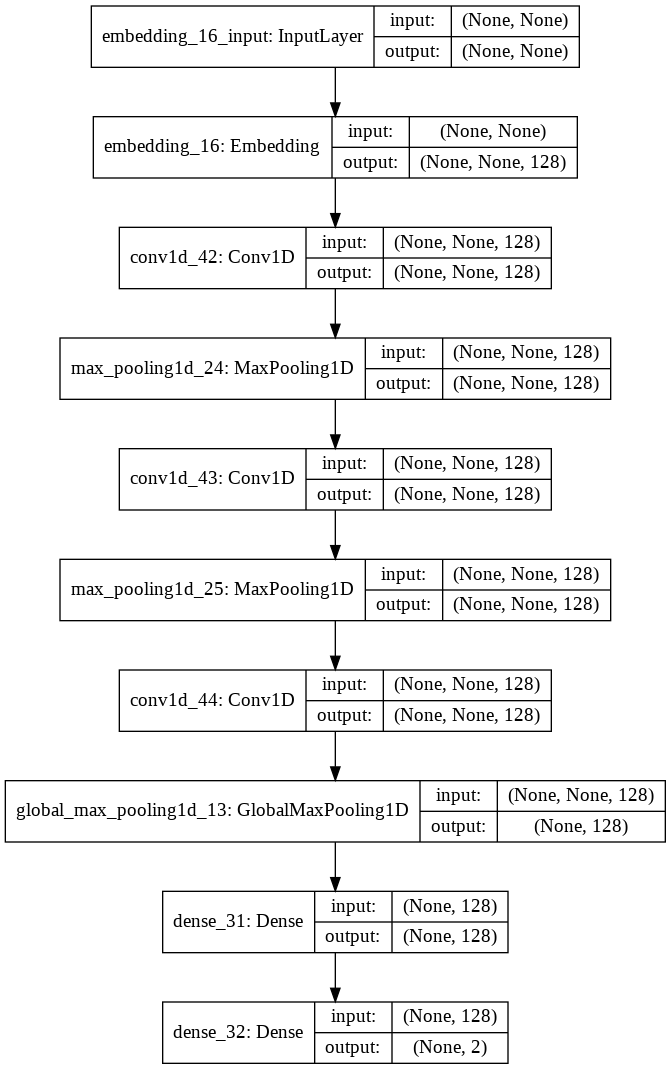

In [72]:
print("Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings")
cnnmodel = Sequential()
cnnmodel.add(Embedding(MAX_NUM_WORDS, 128)) # co the thieu input length = MAX_SEQUENCE_LENGTH (1000)
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(MaxPooling1D(5))
cnnmodel.add(Conv1D(128, 5, activation='relu'))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(128, activation='relu'))
cnnmodel.add(Dense(len(labels_index), activation='softmax'))

cnnmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
print(cnnmodel.summary())
plot_model(cnnmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

#Train the model. Tune to validation set. 
cnnmodel.fit(x_train, y_train,
          batch_size=128,
          epochs=1, validation_data=(x_val, y_val))
#Evaluate on test set:
score, acc = cnnmodel.evaluate(test_data, test_labels)
print('Test accuracy with CNN:', acc)

Defining and training a CNN model, training embedding layer on the fly instead of using pre-trained embeddings


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/1
25000/25000 [==============================] - 102s 4ms/step
Test accuracy with CNN: 0.815559983253479


### LSTM Model with training your own embedding 

In [ ]:
print("Defining and training an LSTM model, training embedding layer on the fly")

#model
rnnmodel = Sequential()
rnnmodel.add(Embedding(MAX_NUM_WORDS, 128))
rnnmodel.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel.add(Dense(2, activation='sigmoid'))
rnnmodel.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
rnnmodel.summary()

Defining and training an LSTM model, training embedding layer on the fly
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 2,691,842
Trainable params: 2,691,842
Non-trainable params: 0
_________________________________________________________________


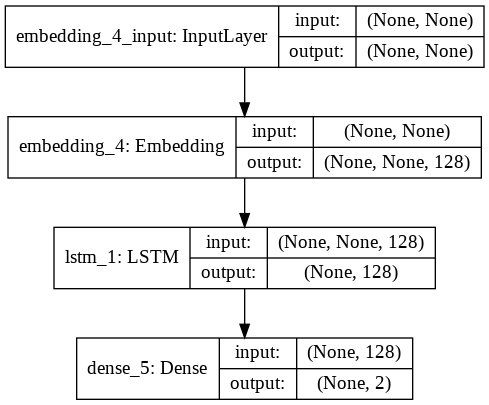

In [ ]:
plot_model(rnnmodel, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:

print('Training the RNN')

rnnmodel.fit(x_train, y_train,
          batch_size=32,
          epochs=1,
          validation_data=(x_val, y_val))
score, acc = rnnmodel.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

Defining and training an LSTM model, training embedding layer on the fly
Training the RNN


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/1
25000/25000 [==============================] - 230s 9ms/step
Test accuracy with RNN: 0.7614399790763855


### LSTM Model using pre-trained Embedding Layer

In [ ]:
print("Defining and training an LSTM model, using pre-trained embedding layer")

rnnmodel2 = Sequential()
rnnmodel2.add(embedding_layer)
rnnmodel2.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
rnnmodel2.add(Dense(2, activation='sigmoid'))
rnnmodel2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print('Training the RNN')

rnnmodel2.fit(x_train, y_train,
          batch_size=32,
          epochs=1,
          validation_data=(x_val, y_val))
score, acc = rnnmodel2.evaluate(test_data, test_labels,
                            batch_size=32)
print('Test accuracy with RNN:', acc)

Defining and training an LSTM model, using pre-trained embedding layer
Training the RNN
Train on 20000 samples, validate on 5000 samples
Epoch 1/1
25000/25000 [==============================] - 267s 11ms/step
Test accuracy with RNN: 0.7980599999427795


# Explain word embedding layer
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

## Example of Learning an Embedding

In [ ]:
# load these pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(input_dim=num_words,#20001 , data encode interger 0-20001 (word index)
                            output_dim=EMBEDDING_DIM, #100
                            embeddings_initializer=Constant(embedding_matrix), #(20001, 100)
                            input_length=MAX_SEQUENCE_LENGTH, #1000
                            trainable=False)

- input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
- output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
- input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

Using TensorFlow backend.


In [ ]:
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])

Next, we can integer encode each document. This means that as input the Embedding layer will have sequences of integers. We could experiment with other more sophisticated bag of word model encoding like counts or TF-IDF.

Keras provides the one_hot() function that creates a hash of each word as an efficient integer encoding. We will estimate the vocabulary size of 50, which is much larger than needed to reduce the probability of collisions from the hash function.

In [ ]:
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)

[[15, 35], [41, 44], [12, 31], [18, 44], [1], [5], [44, 31], [43, 41], [44, 44], [20, 6, 35, 5]]


The sequences have different lengths and Keras prefers inputs to be vectorized and all inputs to have the same length. We will pad all input sequences to have the length of 4. Again, we can do this with a built in Keras function, in this case the pad_sequences() function.

In [ ]:
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

[[15 35  0  0]
 [41 44  0  0]
 [12 31  0  0]
 [18 44  0  0]
 [ 1  0  0  0]
 [ 5  0  0  0]
 [44 31  0  0]
 [43 41  0  0]
 [44 44  0  0]
 [20  6 35  5]]


We are now ready to define our Embedding layer as part of our neural network model.

The Embedding has a vocabulary of 50 and an input length of 4. We will choose a small embedding space of 8 dimensions.

The model is a simple binary classification model. Importantly, the output from the Embedding layer will be 4 vectors of 8 dimensions each, one for each word. We flatten this to a one 32-element vector to pass on to the Dense output layer.

In [ ]:
# define the model
#max_length = 4 words(padding)
#vocab_size = 50
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=8, input_length=max_length))
# output: 4 vectors of 8 dimensions each.
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 8)              400       
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
padded_docs

array([[15, 35,  0,  0],
       [41, 44,  0,  0],
       [12, 31,  0,  0],
       [18, 44,  0,  0],
       [ 1,  0,  0,  0],
       [ 5,  0,  0,  0],
       [44, 31,  0,  0],
       [43, 41,  0,  0],
       [44, 44,  0,  0],
       [20,  6, 35,  5]], dtype=int32)

In [ ]:
labels

array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

In [ ]:
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Accuracy: 80.000001


Combine all to one

encoded_docs
 [[15, 35], [41, 44], [12, 31], [18, 44], [1], [5], [44, 31], [43, 41], [44, 44], [20, 6, 35, 5]]
padded_docs
 [[15 35  0  0]
 [41 44  0  0]
 [12 31  0  0]
 [18 44  0  0]
 [ 1  0  0  0]
 [ 5  0  0  0]
 [44 31  0  0]
 [43 41  0  0]
 [44 44  0  0]
 [20  6 35  5]]
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 4, 8)              400       
_________________________________________________________________
flatten_10 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None


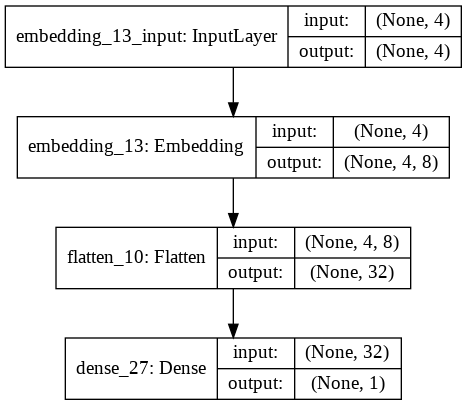

In [69]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.utils.vis_utils import plot_model
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print('encoded_docs\n',encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print('padded_docs\n',padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
plot_model(model, show_shapes=True, show_layer_names=True)


In [68]:
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Accuracy: 80.000001


## Example of Using Pre-Trained GloVe Embedding

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding

In [ ]:
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
print('word_docs\n',t.word_docs)
print('word_index\n',t.word_index)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print('encoded_docs: \n',encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print('padded_docs \n',padded_docs)

word_docs
 defaultdict(<class 'int'>, {'done': 2, 'well': 1, 'work': 3, 'good': 2, 'effort': 2, 'great': 1, 'nice': 1, 'excellent': 1, 'weak': 1, 'poor': 2, 'not': 1, 'could': 1, 'have': 1, 'better': 1})
word_index
 {'work': 1, 'done': 2, 'good': 3, 'effort': 4, 'poor': 5, 'well': 6, 'great': 7, 'nice': 8, 'excellent': 9, 'weak': 10, 'not': 11, 'could': 12, 'have': 13, 'better': 14}
encoded_docs: 
 [[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
padded_docs 
 [[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]


In [ ]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/My Drive/Data/NLP/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


This is pretty slow. It might be better to filter the embedding for the unique words in your training data.

Next, we need to create a matrix of one embedding for each word in the training dataset. We can do that by enumerating all unique words in the Tokenizer.word_index and locating the embedding weight vector from the loaded GloVe embedding.

The result is a matrix of weights only for words we will see during training.

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

Now we can define our model, fit, and evaluate it as before.

The key difference is that the embedding layer can be seeded with the GloVe word embedding weights. We chose the 100-dimensional version, therefore the Embedding layer must be defined with output_dim set to 100. Finally, we do not want to update the learned word weights in this model, therefore we will set the trainable attribute for the model to be False.

In [ ]:
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=4, trainable=False)

In [ ]:
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

In [ ]:
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

Combine to one

In [36]:
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
# define documents
docs = ['Well done!',
		'Good work',
		'Great effort',
		'nice work',
		'Excellent!',
		'Weak',
		'Poor effort!',
		'not good',
		'poor work',
		'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])


# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print('word_docs\n',t.word_docs)
print('word_index\n',t.word_index)
print('encoded_docs\n',encoded_docs)


# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print('padded_docs\n',padded_docs)


# load the whole embedding into memory
embeddings_index = dict()
f = open('/content/drive/My Drive/Data/NLP/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs

print( ' t.word_index.items()\n',t.word_index.items())
embedding_matrix = zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector
print('t.word_index len: ',len(t.word_index))
print('embedding_matrix.shape: ',embedding_matrix.shape)
print('embedding_matrix\n',embedding_matrix)


# define model
model = Sequential()
e = Embedding(input_dim=vocab_size,output_dim=100, weights=[embedding_matrix], input_length=4, trainable=False)
# vocab_size=15, weights or embeddings_initializer (15,100), trainable=False so as tokeep the embeddings fixed
model.add(e)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())


# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

word_docs
 defaultdict(<class 'int'>, {'done': 2, 'well': 1, 'work': 3, 'good': 2, 'effort': 2, 'great': 1, 'nice': 1, 'excellent': 1, 'weak': 1, 'poor': 2, 'not': 1, 'could': 1, 'have': 1, 'better': 1})
word_index
 {'work': 1, 'done': 2, 'good': 3, 'effort': 4, 'poor': 5, 'well': 6, 'great': 7, 'nice': 8, 'excellent': 9, 'weak': 10, 'not': 11, 'could': 12, 'have': 13, 'better': 14}
encoded_docs
 [[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
padded_docs
 [[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]
Loaded 400000 word vectors.
 t.word_index.items()
 dict_items([('work', 1), ('done', 2), ('good', 3), ('effort', 4), ('poor', 5), ('well', 6), ('great', 7), ('nice', 8), ('excellent', 9), ('weak', 10), ('not', 11), ('could', 12), ('have', 13), ('better', 14)])
t.word_index len:  14
embedding_matrix.shape:  (15, 100)
embedding_matrix
 [[ 0.         

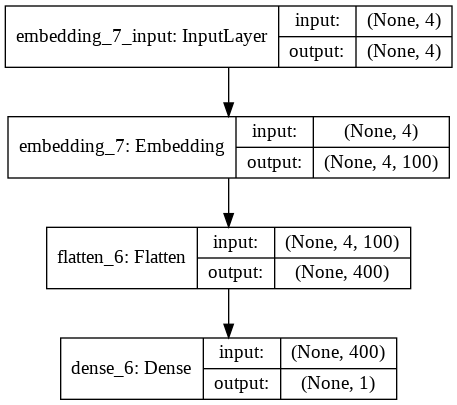

In [32]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)